In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)


from markov_pyactup import *
from statsmodels.formula.api import logit, glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


main_dir = os.path.dirname(os.getcwd())
subject_dir = os.path.join(main_dir, 'data', 'human', 'online_data')
opt_dir = os.path.join(main_dir, 'data', 'model', 'param_optimization_0403')

main_dir, subject_dir, opt_dir

Error trying to connect to ACT-R at 127.0.0.1 : 2651 with exception (<class 'ConnectionRefusedError'>, ConnectionRefusedError(111, 'Connection refused'), <traceback object at 0x7f7ea7faa240>)
ACT-R connection NOT established, but no exception detected or already handled.
Could not start ACT-R connection.


('/home/chery/Documents/Github/ACTR-MarkovTask',
 '/home/chery/Documents/Github/ACTR-MarkovTask/data/human/online_data',
 '/home/chery/Documents/Github/ACTR-MarkovTask/data/model/param_optimization_0403')

## Correlation of `alpha`

Next, let's look at whether two alpha is correlated in two hybrid models. 

We found alpha, bet_mf, lambda, p are significantly correlated between two models

In [2]:
df1 = MarkovEstimation.load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-rl-hybrid'], only_maxLL=1).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value')
df2 = MarkovEstimation.load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-ibl-hybrid'], only_maxLL=1).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value')
dfm = pd.merge(df1.drop(columns=['estimate_model']), df2.drop(columns=['estimate_model']), on=['subject_id', 'param_name'], suffixes=('.rl', '.ibl'))
dfm.head()

,subject_id,param_name,param_value.rl,param_value.ibl
0,1,alpha,1.0000,0.9320
1,2,alpha,0.9459,0.5590
2,3,alpha,0.0090,0.5800
3,4,alpha,0.0546,0.0300
4,5,alpha,0.3763,0.3755


In [3]:
print( 'NUM SUBJ [%d]' % (len(dfm['subject_id'].unique())))

NUM SUBJ [151]


## Distribution of parameters 

### RL

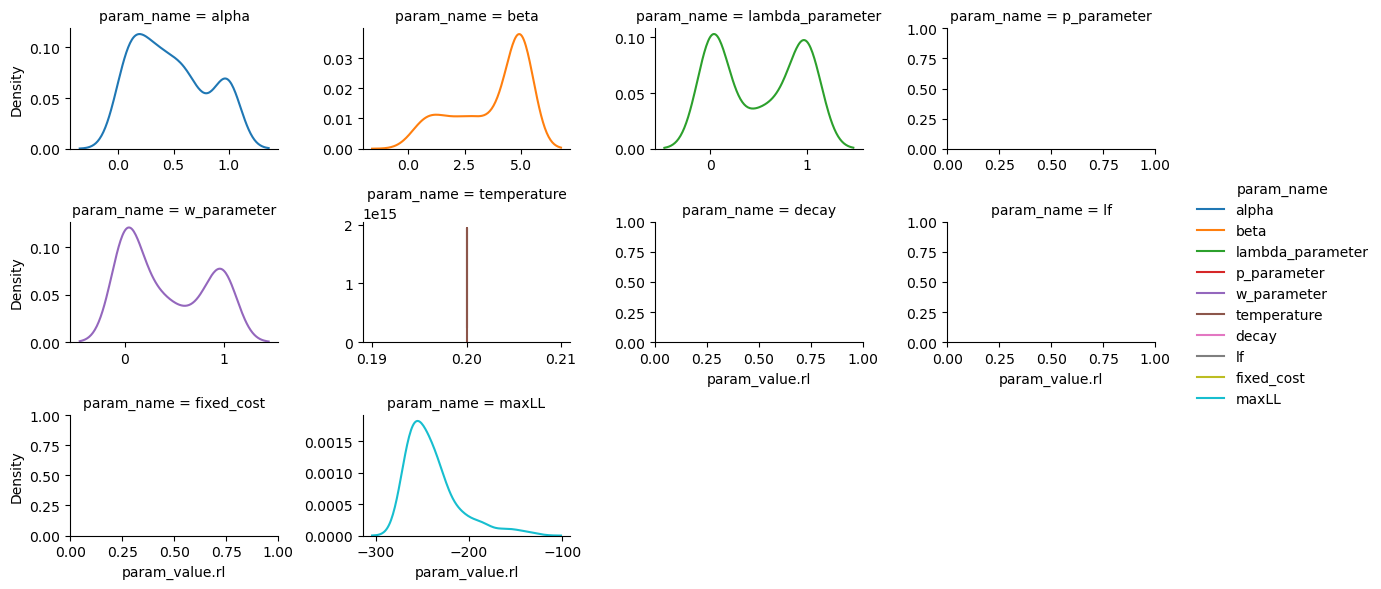

In [4]:
g = sns.displot(data=dfm, x="param_value.rl", hue="param_name", warn_singular=False, 
                col="param_name", col_wrap=4, height=2, aspect=1.5,
                kind="kde", facet_kws=dict(sharey=False, sharex=False))
# sns.move_legend(g, "upper left", ncol=1, title='parameter names', frameon=False, bbox_to_anchor=(1,1))

### IBL

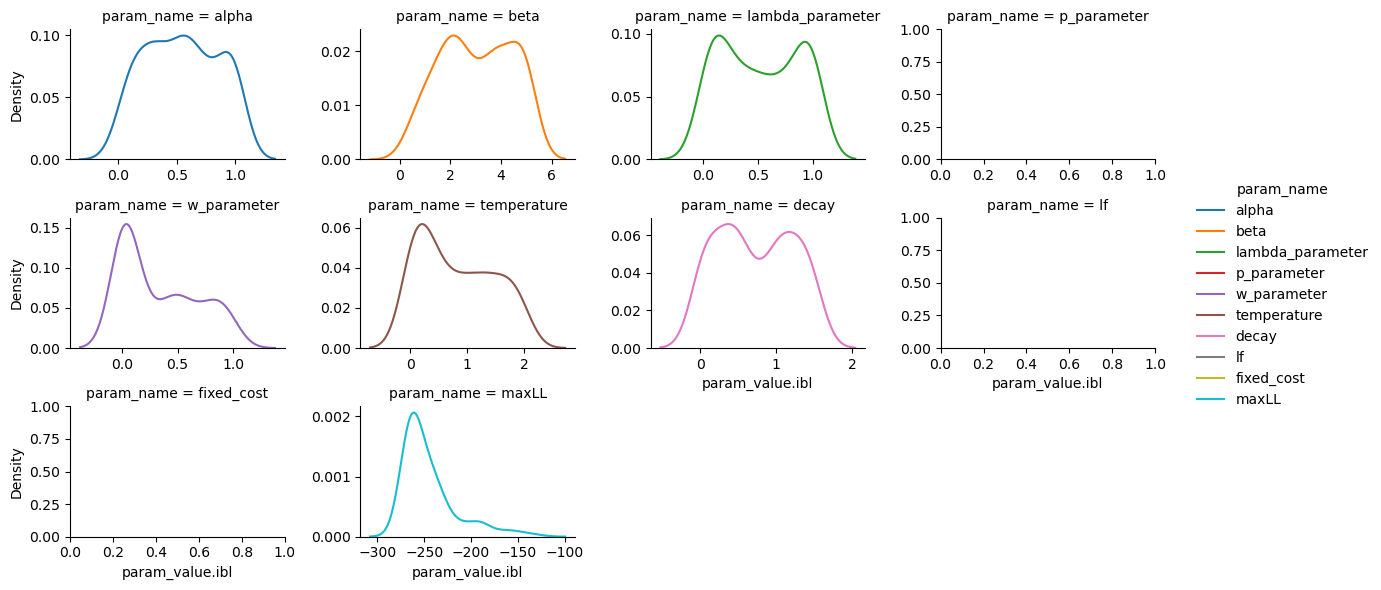

In [5]:
g = sns.displot(data=dfm, x="param_value.ibl", hue="param_name", warn_singular=False, 
                col="param_name", col_wrap=4, height=2, aspect=1.5,
                kind="kde", facet_kws=dict(sharey=False, sharex=False))

## Correlation of parameter sets between IBL vs. RL

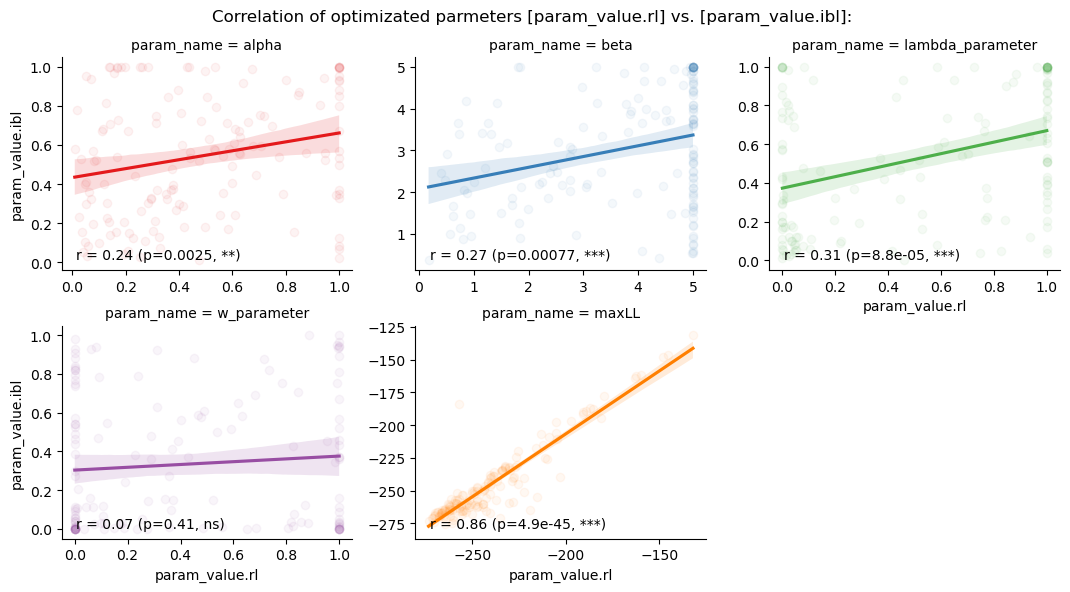

In [6]:
MarkovPlot.parameter_lm_plot(df=dfm, x_name="param_value.rl", y_name="param_value.ibl",  exclude_parameters=['p_parameter', 'temperature', 'decay', 'lf', 'fixed_cost','init'], alpha=0.05)

## Correlation of Age and Parameters

### Age vs. RL

In [7]:
dfa = pd.read_csv(os.path.join(subject_dir, 'mbmf_ages.csv'))
dfa['subject_id'] = dfa['subject_id'].apply(lambda x: int(x[3:]))

dfa = pd.merge(dfm, dfa, on='subject_id', how='left') 

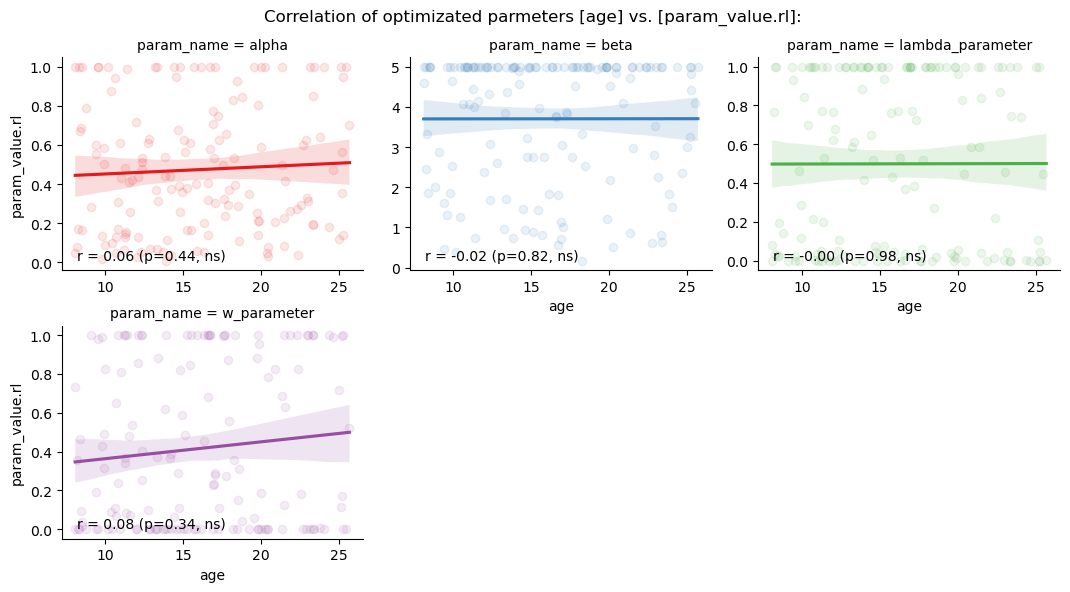

In [8]:
MarkovPlot.parameter_lm_plot(df=dfa, x_name="age", y_name="param_value.rl", exclude_parameters=['p_parameter', 'temperature', 'decay', 'lf', 'fixed_cost', 'maxLL'])

### Correlation of Age and IBL

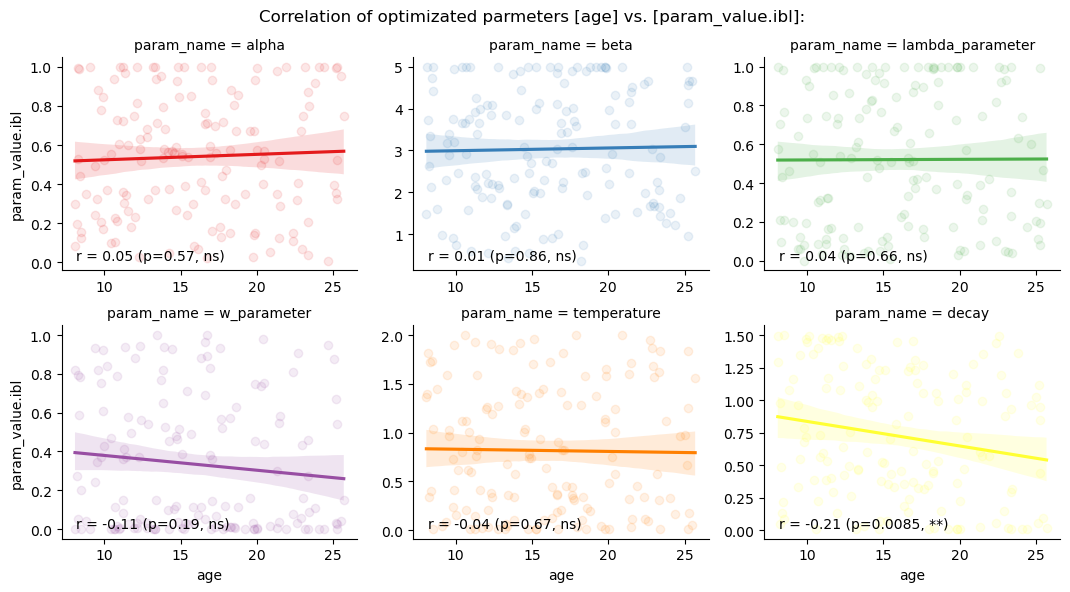

In [9]:
MarkovPlot.parameter_lm_plot(df=dfa, x_name="age", y_name="param_value.ibl",  exclude_parameters=['p_parameter', 'lf', 'fixed_cost', 'maxLL'])

## Age Group



In [10]:
dfa.loc[dfa['age'] <= 12.00, 'age_group'] = 'children'
dfa.loc[(dfa['age'] > 12.00) & (dfa['age'] <= 17.00), 'age_group'] = 'adolescent'
dfa.loc[dfa['age'] > 17.00, 'age_group'] = 'adult'

np.unique(dfa[['subject_id', 'age_group']].drop_duplicates()['age_group'], return_counts=True)

(array(['adolescent', 'adult', 'children'], dtype=object), array([50, 61, 40]))

/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


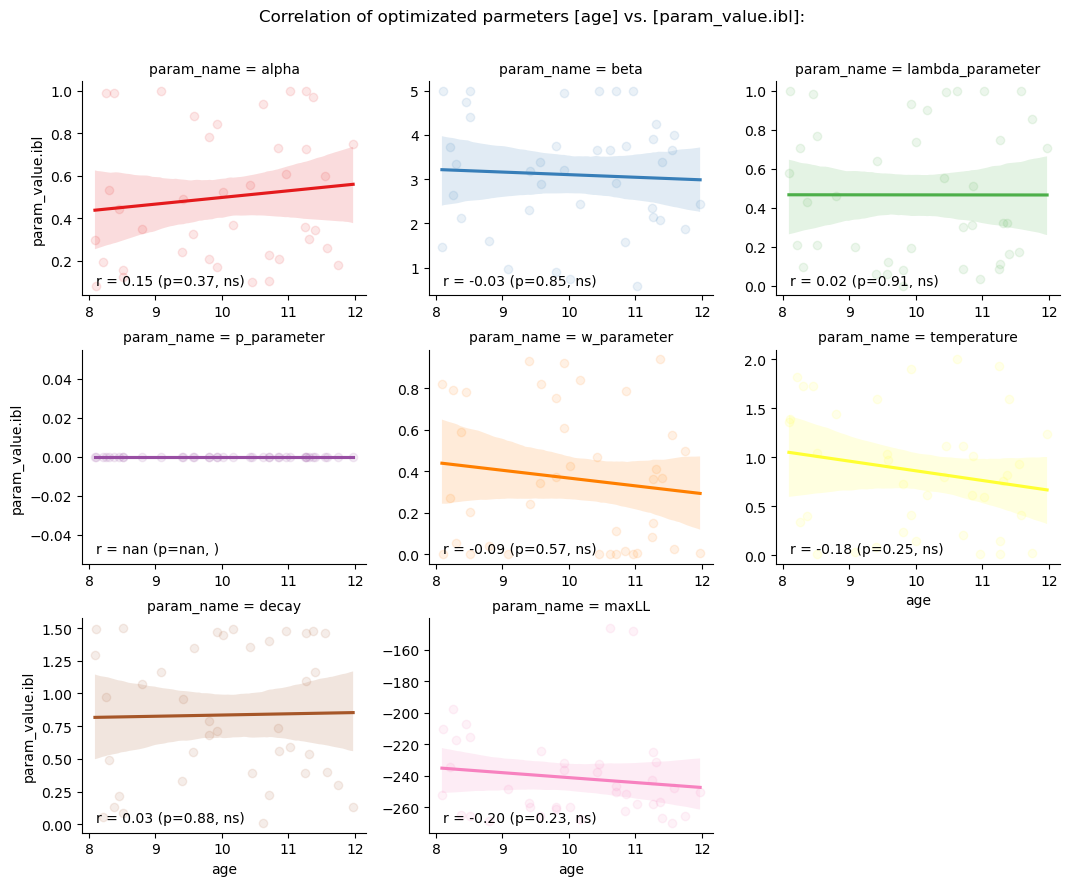

/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


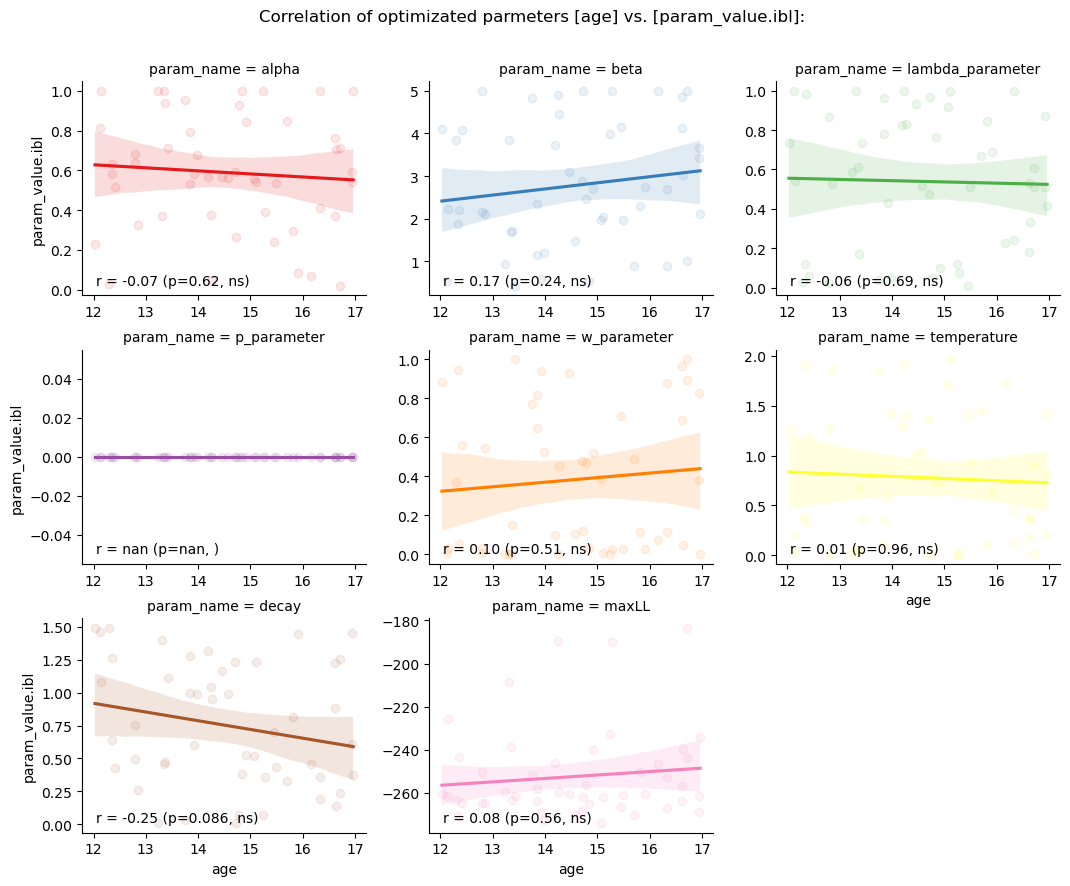

/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


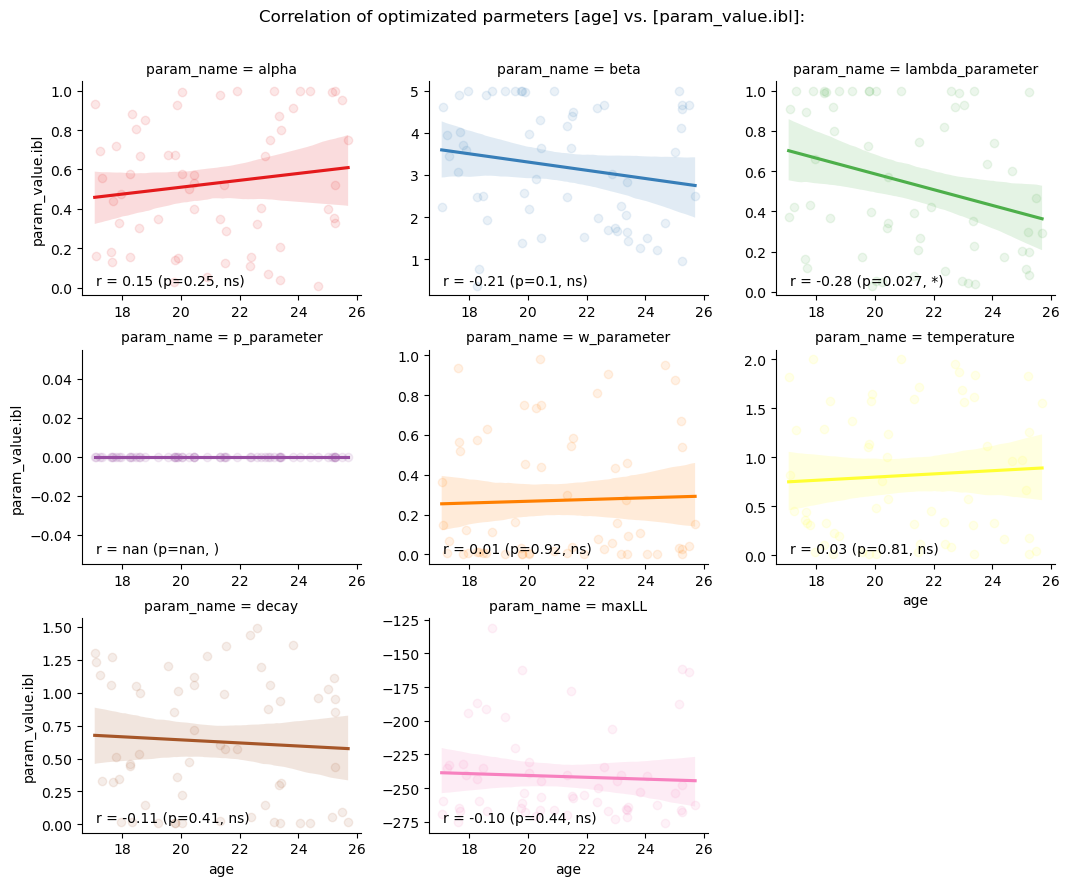

In [11]:
MarkovPlot.parameter_lm_plot(df=dfa.loc[dfa['age_group'] == 'children',:], x_name="age", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfa.loc[dfa['age_group'] == 'adolescent',:], x_name="age", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfa.loc[dfa['age_group'] == 'adult',:], x_name="age", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost'])

## Exclude Outliers

Unfortunately, excluding lowest 5% maxLL subjects does not help

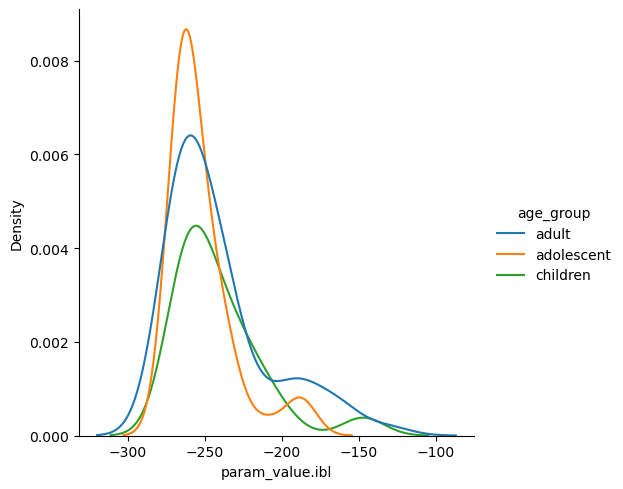

In [12]:
ax = sns.displot(data=dfa[dfa['param_name']=='maxLL'], x='param_value.ibl', hue='age_group', kind='kde')

In [13]:
cut = dfa[dfa['param_name']=='maxLL']['param_value.ibl'].describe(percentiles=[.05, .5, .95])['5%']
drop_subjects = dfa[(dfa['param_name']=='maxLL') & (dfa['param_value.ibl']<=cut)]['subject_id'].unique()
drop_subjects

array([  8,  10,  77,  82, 108, 118, 119, 151])

/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


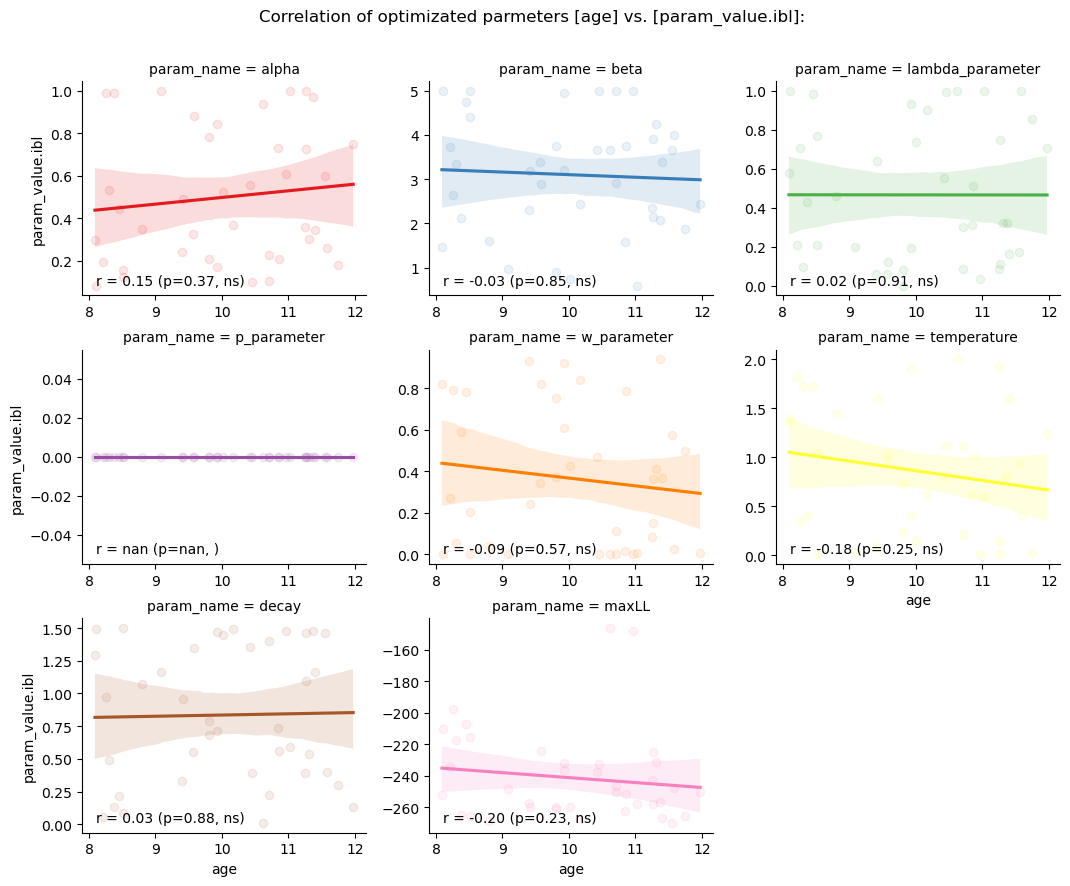

/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


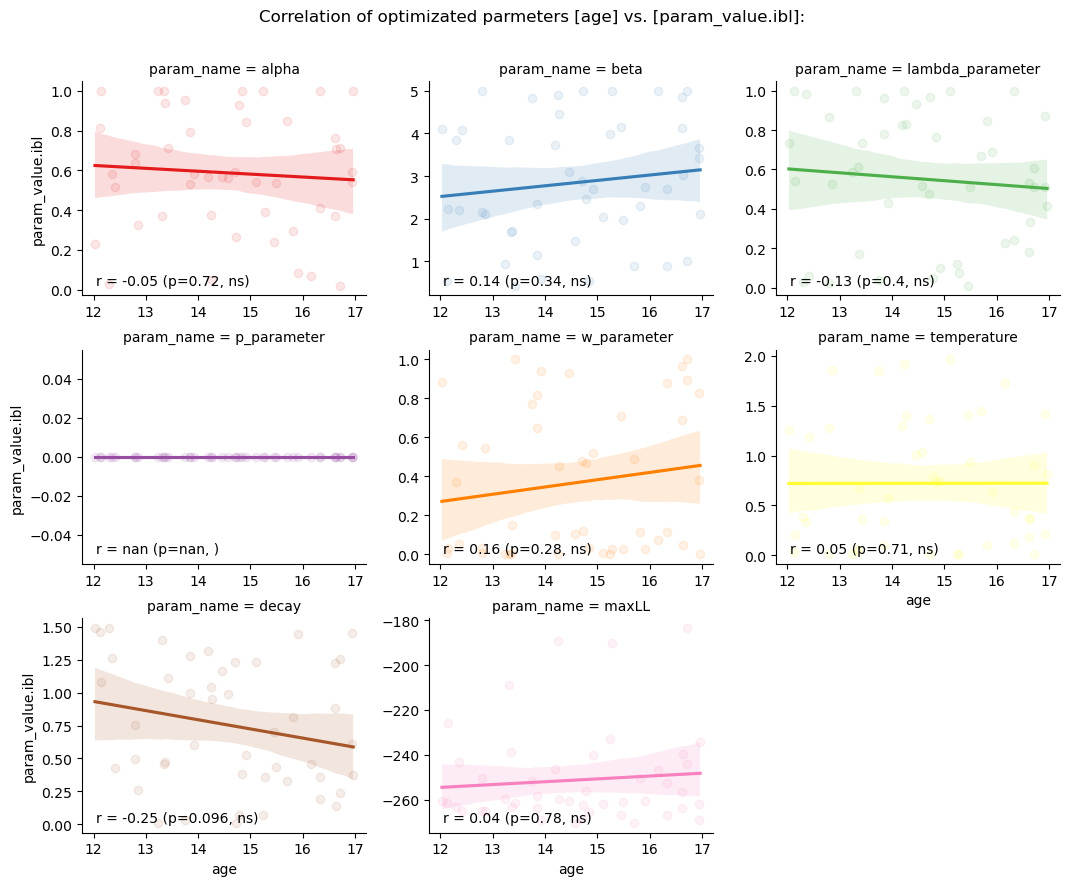

/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


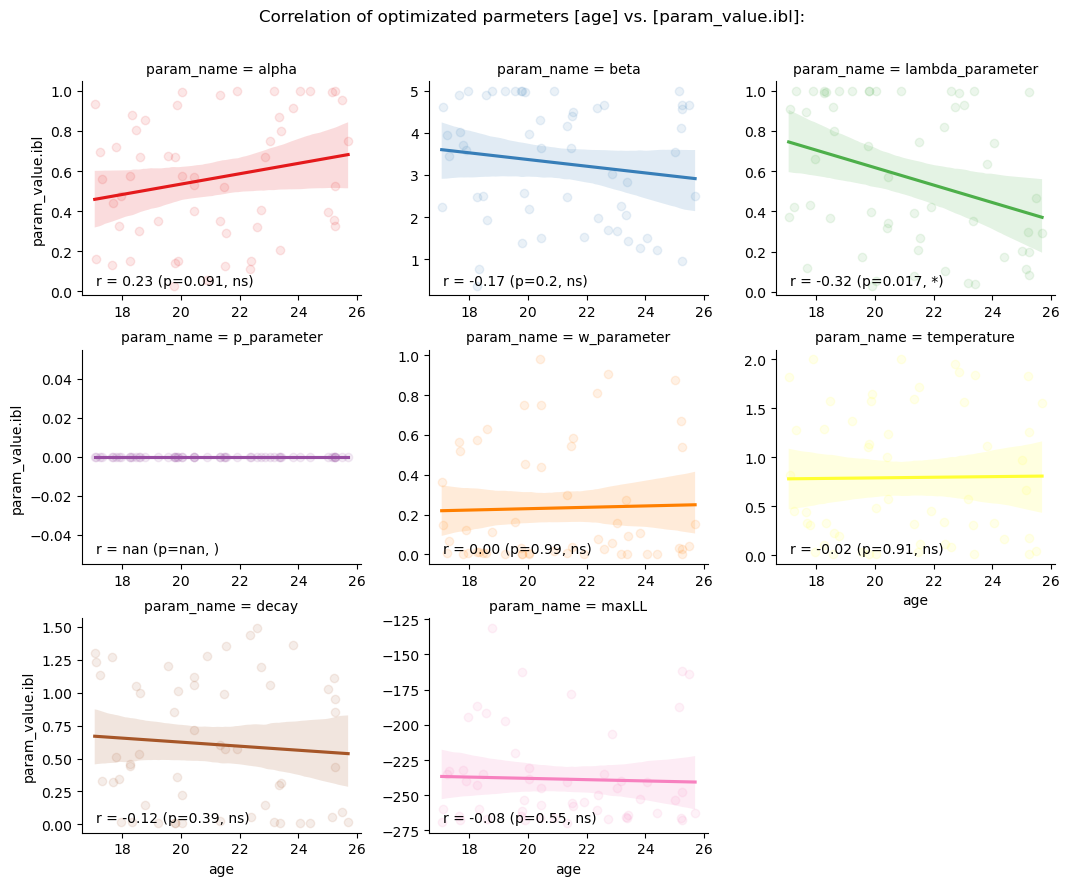

In [14]:
dfaa = dfa[~dfa['subject_id'].isin(drop_subjects)]

MarkovPlot.parameter_lm_plot(df=dfaa.loc[dfaa['age_group'] == 'children',:], x_name="age", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfaa.loc[dfaa['age_group'] == 'adolescent',:], x_name="age", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfaa.loc[dfaa['age_group'] == 'adult',:], x_name="age", y_name="param_value.ibl",  exclude_parameters=['lf', 'fixed_cost'])

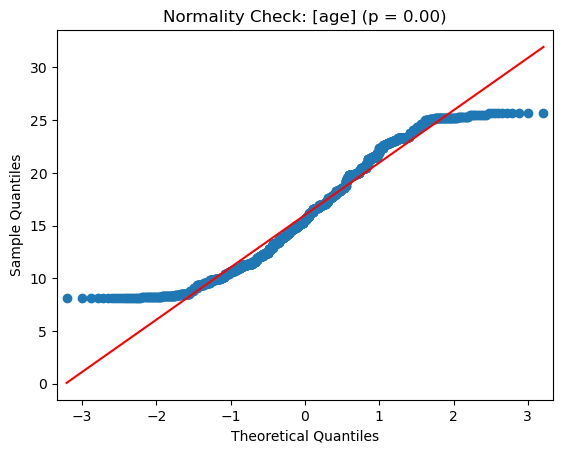

In [15]:
from scipy.stats import shapiro 
from statsmodels.graphics.gofplots import qqplot
 
var_name = 'age'
stat, p = shapiro(dfa[var_name]) 
 
qqplot(dfa[var_name], line='s')
plt.title('Normality Check: [%s] (p = %.2f)' %(var_name, p))
plt.show()